In [41]:
from numpy import array
from numpy import argmax
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
np.random.seed(1671)

Graph plot for training and testing data

In [50]:
def graph_plot(history):
    fig = plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    fig.savefig('error_result.png')

In [15]:
def labelEncoding(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    y = np_utils.to_categorical(y)
    return y

In [42]:
dataset = pd.read_csv('nyc_for_ann.csv')
#dataset = pd.read_csv('nyc_dummies.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713732 entries, 0 to 1713731
Data columns (total 23 columns):
VendorID                 int64
RatecodeID               int64
DOLocationID             int64
passenger_count          int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
payment_type             int64
trip_type                float64
dispatch                 int64
PUT                      object
DOT                      object
PickUp_hr                int64
TMAX                     int64
day                      int64
month                    int64
ride_time_sec            float64
zone                     int64
dtypes: float64(10), int64(11), object(2)
memory usage: 300.7+ MB


Dropped all the features that has high correlation (refer to the correlation test) and date time value

In [43]:
# X = dataset.drop(columns=['dispatch','trip_type', 'VendorID','improvement_surcharge','payment_type','mta_tax','ride_time_sec', 
#                          'RatecodeID','tolls_amount','PUT','DOT'],axis=1)
X = dataset.drop(columns=['PUT','DOT','day','zone'],axis=1)
#X = dataset.drop('zone',axis=1)
#X = dataset[['extra', 'trip_type','trip_distance','payment_type','mta_tax']]
#X = dataset[['VendorID','RatecodeID','passenger_count','trip_distance','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount','dispatch','TMAX','ride_time_sec']]
y = dataset['zone']
del dataset
X.head()

,VendorID,RatecodeID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,dispatch,PickUp_hr,TMAX,month,ride_time_sec
0,2,1,217,1,2.90,14.5,0.0,0.5,0.00,0.0,0.3,15.30,2,1.0,1,11,33,1,1117.0
1,2,1,91,6,4.77,16.5,0.5,0.5,0.00,0.0,0.3,17.80,2,1.0,1,22,33,1,1033.0
2,2,1,74,1,1.95,11.5,0.0,0.5,0.00,0.0,0.3,12.30,1,1.0,1,14,33,1,945.0
3,1,1,217,1,2.20,12.5,0.5,0.5,2.75,0.0,0.3,16.55,1,1.0,1,23,33,1,1021.0
4,2,1,4,1,2.82,13.0,0.5,0.5,1.00,0.0,0.3,15.30,1,1.0,1,23,33,1,921.0


We decide to randomly drop with the dropout probability some of the values propagated inside our internal dense network of hidden layers. In machine learning, this is a well-known form of regularization

In [5]:
NB_EPOCH = 50
BATCH_SIZE = 100
VALIDATION_SPLIT=0.2
VERBOSE = 1
OPTIMIZER = Adam(lr=0.001, decay = (0.001) / NB_EPOCH ) # optimizer, explained later in this chapter
N_HIDDEN = 128
DROPOUT = 0.3

We have to map the zones to distinct categories; example in our target column we have something like 7,7,7,5,6,3,2... which are our zones. Now first we decide how many unique zones/classes are here. Then map each zones to a value here its a vector. Example for zone 7 it would [0,0,0,0,0,0,1,0,0,0,0,0,0,....]

In [6]:
def OneHotEncoding(y):
    data = array(y)
    encoded = to_categorical(data)
    print(np.shape(encoded))
    return encoded

Multilayer Perceptron Model

In [7]:
def model(N_HIDDEN,RESHAPED,NB_CLASSES,OPTIMIZER,DROPOUT):
    model = Sequential()
    model.add(Dense(N_HIDDEN, input_shape=(RESHAPED,)))
    model.add(Activation('relu'))
    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    #model.add(Dropout(DROPOUT))
    model.add(Dense(NB_CLASSES))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy'])
    return model

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
RESHAPED = len(X_train.columns)

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

c:\users\user\appdata\local\conda\conda\envs\tf_gpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
y_train = OneHotEncoding(y_train)

(1370985, 261)


In [11]:
#unique_elements, counts_elements = np.unique(y_train, return_counts=True)
NB_CLASSES = y_train.shape[1]

In [12]:
model= model(N_HIDDEN,RESHAPED,NB_CLASSES,OPTIMIZER,DROPOUT)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2560      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 261)               33669     
_________________________________________________________________
activation_3 (Activation)    (None, 261)               0         
Total params: 52,741
Trainable params: 52,741
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train,
batch_size=BATCH_SIZE, epochs=NB_EPOCH,
verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 1096788 samples, validate on 274197 samples
Epoch 1/50
1096788/1096788 [==============================] - 36s 33us/step - loss: 2.7183 - acc: 0.1907 - val_loss: 2.5488 - val_acc: 0.2325
Epoch 2/50
1096788/1096788 [==============================] - 34s 31us/step - loss: 2.4561 - acc: 0.2527 - val_loss: 2.3587 - val_acc: 0.2727
Epoch 3/50
1096788/1096788 [==============================] - 34s 31us/step - loss: 2.2947 - acc: 0.2878 - val_loss: 2.2405 - val_acc: 0.2999
Epoch 4/50
1096788/1096788 [==============================] - 34s 31us/step - loss: 2.1967 - acc: 0.3065 - val_loss: 2.1683 - val_acc: 0.3085
Epoch 5/50
1096788/1096788 [==============================] - 34s 31us/step - loss: 2.1341 - acc: 0.3187 - val_loss: 2.1064 - val_acc: 0.3239
Epoch 6/50
1096788/1096788 [==============================] - 34s 31us/step - loss: 2.0888 - acc: 0.3278 - val_loss: 2.0723 - val_acc: 0.3320
Epoch 7/50
1096788/1096788 [==============================] - 34s 31us/step - loss: 2.0537 - ac

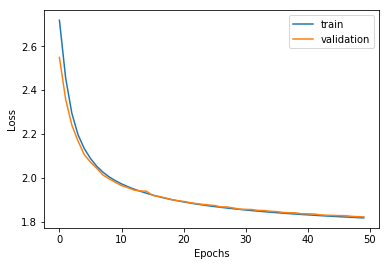

In [52]:
graph_plot(history)

Prediction

In [19]:
y_test = OneHotEncoding(y_test)

(342747, 261)


In [20]:
score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("Test score:", score[0])
print('Test accuracy:', score[1])

342747/342747 [==============================] - 10s 28us/step
Test score: 1.8268432333566031
Test accuracy: 0.39709756759324166


In [24]:
prediction = model.predict_classes(X_test, verbose=1)

342747/342747 [==============================] - 6s 17us/step


In [25]:
prediction.csv('prediction.csv')

AttributeError: 'numpy.ndarray' object has no attribute 'csv'

In [26]:
np.savetxt("prediction.csv", prediction, delimiter=",")

In [45]:
np.savetxt("features.csv",X_train,delimiter=",")

In [46]:
np.savetxt("targets.csv",y_train,delimiter=",")

In [40]:
del dataset
del data_to_predict
del y_train
del X_train

NameError: name 'dataset' is not defined